# Chatbot

In [1]:
# !pip install python-utils

In [1]:
import os
import openai
from openai import OpenAI
import sys
import time
import string
import re
import pandas as pd
import numpy as np
import psycopg2
sys.path.append('../..')
import python_utils
import torch
import ast
from transformers import BartForConditionalGeneration, BartTokenizer, BertTokenizer, BertTokenizerFast, BertForSequenceClassification, AdamW
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt

# from dotenv import loader_dotenv, find_dotenv

API_KEY = ''
client = OpenAI(api_key = API_KEY)
openai.api_key = API_KEY

## Helper Functions

In [2]:
# This function receives an array of 'messages' and returns an output based on this array.
# INPUTS:
#      * messages: an array of messages between user and gpt model.
#      * TODO: complete
def get_completion_from_messages(messages, model="gpt-3.5-turbo-16k", temperature=0, max_tokens=500):
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    last_message = response.choices[0].message
    return last_message.content

def get_prompt_ambig_category(user_prompt):
    BERT_tokenizer = BertTokenizer.from_pretrained('../models/final_pretrained_saves_BERT')
    BERT_model = BertForSequenceClassification.from_pretrained('../models/final_pretrained_saves_BERT')
    BERT_model.eval()
    
    inputs = BERT_tokenizer(user_prompt, padding=True, truncation=True, return_tensors='pt')
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    
    with torch.no_grad():
        outputs = BERT_model(input_ids, attention_mask=attention_mask)
        
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    query_classification = torch.argmax(probabilities, dim=1).item()
    
    return query_classification


def get_prompt_rephrase(ambiguous_prompt):
    BART_tokenizer = BartTokenizer.from_pretrained('../models/final_pretrained_saves')
    BART_model = BartForConditionalGeneration.from_pretrained('../models/final_pretrained_saves')    
    BART_model.eval()
    
    inputs = BART_tokenizer.encode(ambiguous_prompt, return_tensors="pt", max_length=512, truncation=True)
    
    with torch.no_grad():
        outputs = BART_model.generate(inputs, max_length=512, num_beams=5, early_stopping=True)
    
    disambiguated_question = BART_tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return disambiguated_question


def get_tokenized_responses(response):
    tokenized_response = response.split()
    return tokenized_response


def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def embed_user_prompt(user_prompt, model="text-embedding-ada-002"):
    
    # try:
    #     # Create the embedding
    #     response = client.embeddings.create(input=[user_prompt], model=model)
    #     embedding = response.data[0].embedding
    #     return embedding
    # except Exception as e:
    #     # Handle exceptions
    #     print(f"An error occurred: {e}")
    #     return None
    
    response = client.embeddings.create(input=[user_prompt], model=model)
    embedding = response.data[0].embedding
    return embedding
    

# TODO
def get_content_from_database(embedded_user_prompt, df):
    
    embedded_user_prompt = embedded_user_prompt.reshape(1, -1)
    page_embeddings = np.vstack(df['page_embedding'])
    similarities = cosine_similarity(embedded_user_prompt, page_embeddings)
    most_similar_index = np.argmax(similarities)

    return df.iloc[most_similar_index]['page_content']
    


## Test Data Loading

In [11]:
test_df = pd.read_csv('../../data/GPT/GPT_test_final_csv')
test_df = test_df.drop(columns=['question_type', 'viewed_doc_titles', 'disambiguated_question'])
test_df.head()

,ambiguous_question,answer,page_content
0,The first article of the texas constitution co...,bill of rights,~~The <b>Constitution</b> of the State of <b>T...
1,The first article of the texas constitution co...,the three branches of government,~~The <b>Constitution</b> of the State of <b>T...
2,Who played the marshal in who shot liberty val...,Andy Devine,~~The Man <b>Who Shot Liberty Valance</b> is a...
3,Who played the marshal in who shot liberty val...,Robert G. Slade,~~The Man <b>Who Shot Liberty Valance</b> is a...
4,What are the two types of mixtures in science?,homogeneous mixture,"~~In chemistry, a mixture is a material made u..."


In [4]:
embeddings_df = pd.DataFrame(test_df['page_content'])
test_df = test_df.drop(columns=['page_content'])

In [5]:
# CITATION: https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

embeddings_df['page_content'] = embeddings_df['page_content'].apply(remove_html_tags)
embeddings_df.head()

,page_content
0,~~The Constitution of the State of Texas is th...
1,~~The Constitution of the State of Texas is th...
2,~~The Man Who Shot Liberty Valance is a 1962 A...
3,~~The Man Who Shot Liberty Valance is a 1962 A...
4,"~~In chemistry, a mixture is a material made u..."


In [6]:
# embedding_model = "text-embedding-ada-002"
# embeddings = []

# # CITATION: https://platform.openai.com/docs/guides/embeddings/use-cases
# 
# def get_embedding(text, model="text-embedding-ada-002", max_length = 8000):
#     # text = text.replace("\n", " ")[:max_length]
#     # return client.embeddings.create(input=[text], model=model).data[0].embedding
#     text = text.replace("\n", " ")[:max_length]
#     try:
#         return client.embeddings.create(input=[text], model=model).data[0].embedding
#     except Exception as e:
#         print(f"Error occurred: {e}")
#         time.sleep(10)  # Wait for 10 seconds before retrying
#         return None
    
# embeddings = []
# counter = 0
# for row in embeddings_df['page_content']:
#     if counter%200==0:
#         print(counter)
        
#     embedding = get_embedding(row, model='text-embedding-ada-002')
#     embeddings.append(embedding)
#     counter+=1

# embeddings_df['page_embedding'] = embeddings


In [7]:
# embeddings_df.to_csv('embedded_page_contents.csv', index=False)

In [8]:
embeddings_df = pd.read_csv('embedded_page_contents.csv')
embeddings_df['page_embedding'] = embeddings_df['page_embedding'].apply(ast.literal_eval)

In [9]:
embeddings_df.head()

,page_content,page_embedding
0,~~The Constitution of the State of Texas is th...,"[-0.0027238428592681885, 0.020244302228093147,..."
1,~~The Constitution of the State of Texas is th...,"[-0.0027419731486588717, 0.020274952054023743,..."
2,~~The Man Who Shot Liberty Valance is a 1962 A...,"[-0.020264700055122375, -0.018238229677081108,..."
3,~~The Man Who Shot Liberty Valance is a 1962 A...,"[-0.020236164331436157, -0.0182228721678257, 0..."
4,"~~In chemistry, a mixture is a material made u...","[0.006561756134033203, 0.02816181816160679, -0..."


In [10]:
test_df_SAMPLE = test_df.sample(n=100, random_state=42)
test_df_SAMPLE.head()

,ambiguous_question,answer
596,What is the classification of a loggerhead sea...,Testudines
4507,Where will the super rugby final be played?,"Ellis Park Stadium, Johannesburg"
3049,Who controls the house of representatives righ...,The Democratic Party
2957,Who is opening for luke bryan kill the lights ...,Brett Eldredge
8,Who hit the longest drive in golf history?,Mike Dobbyn


## Chatbot with Ambiguous Query Processing

In [ ]:
panels = []
delimiter = "~~~~"
start_convo_flag = True

context = [{'role': 'system', 'content':f"""

You are a chatbot that for 'fact-based' or 'direct' questioning. You will be provided a question and you must provide an answer. \
You answer must be short. Do not include explanations to the provided question. Here is an example:

Question: What is the capital of Japan?

Answer: Tokyo.


"""}] # accumulate messages


context.append({'role':'user', 'content':f"{delimiter}Hi!{delimiter}"})
init_response = get_completion_from_messages(context)

print("-- Chatbot: ", init_response, "\n")
while start_convo_flag:
    print("-- User: ")
    user_input = input()
    print()
    if user_input == "stop":
        break
        
    # Check if conversation is an ambiguous question or not
    is_ambiguous = get_prompt_ambig_category(user_input)
    print("IS AMBIGUOUS? ", is_ambiguous)
    
    # conversation_history = [entry for entry in context if entry['role'] != 'system']
    # continuation_flag = int(is_continuation(conversation_history, user_input)
    
    # Match question with NQ Dataset
    # db_content = get_content_from_database(user_input)
    
    if is_ambiguous == 1:
        print("QUESTION IS AMBIGUOUS!")
        rephrased_user_input = get_prompt_rephrase(user_input)
        print("REPHRASED QUESTION: ", rephrased_user_input)
        user_input = rephrased_user_input
            
    # # Add System instructions
    # context.append({'role':'system', 'content': f"""Use the provided content to answer the question.\
    #                 Do not make assumptions or use information from your pre-trained data. Use this information: {db_content}"""})

    # Input User's question
    context.append({'role': 'user', 'content': f"{delimiter}{user_input}{delimiter}"})
    response = get_completion_from_messages(context)
    print("-- Chatbot: ", response, "\n")
    context.append({'role': 'assistant', 'content': f"{response}"})
    



-- Chatbot:  Hello! How can I assist you today? 

-- User: 


 Where did Harry Potter go to school?



IS AMBIGUOUS?  1
QUESTION IS AMBIGUOUS!
REPHRASED QUESTION:  Where did Harry Potter go to school in Harry Potter and the Chamber of Secrets?
-- Chatbot:  Hogwarts. 

-- User: 


 Where did Harry Potter go to school in Harry Potter and the Prisoner of Azkaban?



IS AMBIGUOUS?  0
-- Chatbot:  Hogwarts. 

-- User: 


In [16]:
panels = []
bleu_scores_array = []
meteor_scores_array = []
bert_scores = []
counter = 0

delimiter = "==="

context = [{'role': 'system', 'content':f"""

You are a chatbot that for 'fact-based' or 'direct' questioning. You will be provided a question and you must provide an answer. \
You answer must be short. Do not include explanations to the provided question. Here is an example:

Question: What is the capital of Japan?

Answer: Tokyo.

Answer the user's prompt, delimited by {delimiter}

"""}] # accumulate messages


# for index, row in test_df_SAMPLE.iterrows(): # 200 samples!
   
user_input = test_df_SAMPLE.iloc[0]['ambiguous_question']
print(" -- User prompt: ", user_input)

# Check if conversation is an ambiguous question or not
is_ambiguous = get_prompt_ambig_category(user_input)
# print("IS AMBIGUOUS? ", is_ambiguous)


if is_ambiguous == 1:
    print("QUESTION IS AMBIGUOUS!")
    rephrased_user_input = get_prompt_rephrase(user_input)
    # print("REPHRASED QUESTION: ", rephrased_user_input)
    user_input = rephrased_user_input
    print(" -- New User prompt: ", user_input)

embedded_user_prompt =np.array(embed_user_prompt(user_input))

db_page_contents = get_content_from_database(embedded_user_prompt, embeddings_df)
print("Contents: ", db_page_contents)

# Add System instructions
context.append({'role':'system', 'content': f"""Use the provided content to answer the question.\
                Do not make assumptions or use information from your pre-trained data. If the answer is not explicitly mentioned in the provided information, \
                reply with 'unknown'. Use this information: {db_page_contents}"""})

# Input User's question
context.append({'role': 'user', 'content': f"{delimiter}{user_input}{delimiter}"})
response = get_completion_from_messages(context).lower()

# BLEU SCORE
response = remove_punctuation(response)
tokenized_response = get_tokenized_responses(response)
tokenized_actual = get_tokenized_responses(remove_punctuation(test_df_SAMPLE.iloc[0]['answer']))
smooth_fn = SmoothingFunction().method1
# CITATION: Had to change this line of code to work with small answers. Help from ChatGPT.
bleu_score = sentence_bleu([tokenized_response], tokenized_actual, weights=(0.5, 0.5), smoothing_function=smooth_fn)
print(tokenized_response,tokenized_actual)
print("BLEU Score: ", bleu_score)
bleu_scores_array.append(bleu_score)

# METEOR SCORE
meteor_scored = meteor_score([tokenized_response], tokenized_actual)
print("METEOR Score: ", meteor_scored)
meteor_scores_array.append(meteor_scored)

context = context[:1] # reset the context array
    



# print(bleu_scores_array, meteor_scores_array)

 -- User prompt:  What is the classification of a loggerhead sea turtle?
QUESTION IS AMBIGUOUS!
 -- New User prompt:  What is the general classification of a loggerhead sea turtle?
Contents:  ~~The subspecific classification of the loggerhead sea turtle is debated, but most 
authors consider it a single polymorphic species.~~Sea turtles (superfamily Chelonioidea), sometimes called marine turtles, are 
reptiles of the order Testudines and of the suborder Cryptodira. The seven 
existing species of sea turtles are the green sea turtle, loggerhead ... An 
additional three species are classified as &quot;Vulnerable&quot;. The flatback sea turtle is 
considered as &quot;Data&nbsp;...~~Cheloniidae is a family of typically large marine turtles that are characterised by 
their common ... The green and loggerhead sea turtles are categorized as 
endangered, Olive Ridleys are classified as vulnerable, Kemp&#39;s Ridleys, and 
Hawksbills sea turtles are critically endangered and the Flat Back sea t

In [20]:
panels = []
bleu_scores_array = []
meteor_scores_array = []
bert_scores = []
counter = 0

delimiter = "==="

context = [{'role': 'system', 'content':f"""

You are a chatbot that for 'fact-based' or 'direct' questioning. You will be provided a question and you must provide an answer. \
You answer must be short. Do not include explanations to the provided question. Here is an example:

Question: What is the capital of Japan?

Answer: Tokyo.

Answer the user's prompt, delimited by {delimiter}

"""}] # accumulate messages


for index, row in test_df_SAMPLE.iterrows(): # 200 samples!
    counter+=1
    if counter%10==0:
        print(counter)
        # time.sleep(3)
    user_input = row['ambiguous_question']
    print(" -- User prompt: ", user_input)

    # Check if conversation is an ambiguous question or not
    is_ambiguous = get_prompt_ambig_category(user_input)
    # print("IS AMBIGUOUS? ", is_ambiguous)
    

    if is_ambiguous == 1:
        print("QUESTION IS AMBIGUOUS!")
        rephrased_user_input = get_prompt_rephrase(user_input)
        # print("REPHRASED QUESTION: ", rephrased_user_input)
        user_input = rephrased_user_input
        print(" -- New User prompt: ", user_input)

    embedded_user_prompt =np.array(embed_user_prompt(user_input))

    db_page_contents = get_content_from_database(embedded_user_prompt, embeddings_df)
    print("Contents: ", db_page_contents)

    # Add System instructions
    context.append({'role':'system', 'content': f"""Use the provided content to answer the question.\
                    Do not make assumptions or use information from your pre-trained data. If the answer is not explicitly mentioned in the provided information, \
                    reply with 'unknown'. Use this information: {db_page_contents}"""})

    # Input User's question
    context.append({'role': 'user', 'content': f"{delimiter}{user_input}{delimiter}"})
    response = get_completion_from_messages(context).lower()

    # BLEU SCORE
    response = remove_punctuation(response)
    tokenized_response = get_tokenized_responses(response)
    tokenized_actual = get_tokenized_responses(remove_punctuation(row['answer']))
    smooth_fn = SmoothingFunction().method1
    # CITATION: Had to change this line of code to work with small answers. Help from ChatGPT.
    bleu_score = sentence_bleu([tokenized_response], tokenized_actual, weights=(0.5, 0.5), smoothing_function=smooth_fn)
    print(tokenized_response,tokenized_actual)
    print("BLEU Score: ", bleu_score)
    bleu_scores_array.append(bleu_score)

    # METEOR SCORE
    meteor_scored = meteor_score([tokenized_response], tokenized_actual)
    print("METEOR Score: ", meteor_scored)
    meteor_scores_array.append(meteor_scored)
    
    context = context[:1] # reset the context array
    
    time.sleep(3)


# print(bleu_scores_array, meteor_scores_array)

 -- User prompt:  What is the classification of a loggerhead sea turtle?
QUESTION IS AMBIGUOUS!
 -- New User prompt:  What is the general classification of a loggerhead sea turtle?
Contents:  ~~The subspecific classification of the loggerhead sea turtle is debated, but most 
authors consider it a single polymorphic species.~~Sea turtles (superfamily Chelonioidea), sometimes called marine turtles, are 
reptiles of the order Testudines and of the suborder Cryptodira. The seven 
existing species of sea turtles are the green sea turtle, loggerhead ... An 
additional three species are classified as &quot;Vulnerable&quot;. The flatback sea turtle is 
considered as &quot;Data&nbsp;...~~Cheloniidae is a family of typically large marine turtles that are characterised by 
their common ... The green and loggerhead sea turtles are categorized as 
endangered, Olive Ridleys are classified as vulnerable, Kemp&#39;s Ridleys, and 
Hawksbills sea turtles are critically endangered and the Flat Back sea t

KeyboardInterrupt: 

In [12]:
# response = remove_punctuation(response)

# tokenized_response = get_tokenized_responses(response)
# tokenized_actual = get_tokenized_responses(test_df.iloc[0]['answer'])
# print(response)
# print(tokenized_response)
# print()
# print(test_df.iloc[0]['answer'])
# print(tokenized_actual)

# smooth_fn = SmoothingFunction().method1

# # CITATION: Had to change this line of code to work with small answers. Help from ChatGPT.
# bleu_score = sentence_bleu([tokenized_response], tokenized_actual, weights=(0.5, 0.5), smoothing_function=smooth_fn)

# print(bleu_score)

the bill of rights
['the', 'bill', 'of', 'rights']

bill of rights
['bill', 'of', 'rights']
0.7165313105737893


In [17]:
# print([tokenized_response])
# print(tokenized_actual)

# meteor_scores = meteor_score([tokenized_response], tokenized_actual)
# print(meteor_scores)

average_meteor_score = sum(meteor_scores_array) / len(meteor_scores_array)
print(average_meteor_score)

0.11366781666441263


In [18]:
average_bleu_score = sum(bleu_scores_array) / len(bleu_scores_array)
print(average_bleu_score)

0.016821592920681017


In [5]:
# TODO
# - Change script to test on the test AmbigNQ data
# - Prompt-engineer GPT model to output short answers.
# - Extract each ChatGPT output and Compare answers using embedding model and thus euclidean similarity?

# Potential Improvements
# - Hallucination tracking
# - RAG system with GoogleNQ dataset

## Chatbot without Ambiguous Query Processing

In [29]:
panels = []
bleu_scores_array = []
meteor_scores_array = []
bert_scores = []
counter = 0

delimiter = "==="

context = [{'role': 'system', 'content':f"""

You are a chatbot that for 'fact-based' or 'direct' questioning. You will be provided a question and you must provide an answer. \
You answer must be short. Do not include explanations to the provided question. Here is an example:

Question: What is the capital of Japan?

Answer: Tokyo.

Answer the user's prompt, delimited by {delimiter}

"""}] # accumulate messages


for index, row in test_df_SAMPLE.iterrows(): # 100 samples!
    counter+=1
    if counter%10==0:
        print(counter)
        # time.sleep(3)
    user_input = row['ambiguous_question']
    # print(" -- User prompt: ", user_input)


    embedded_user_prompt =np.array(embed_user_prompt(user_input))

    db_page_contents = get_content_from_database(embedded_user_prompt, embeddings_df)
    # print("Contents: ", db_page_contents)

    # Add System instructions
    context.append({'role':'system', 'content': f"""Use the provided content to answer the question.\
                    Do not make assumptions or use information from your pre-trained data. If the answer is not explicitly mentioned in the provided information, \
                    reply with 'unknown'. Use this information: {db_page_contents}"""})

    # Input User's question
    context.append({'role': 'user', 'content': f"{delimiter}{user_input}{delimiter}"})
    response = get_completion_from_messages(context).lower()

    # BLEU SCORE
    response = remove_punctuation(response)
    tokenized_response = get_tokenized_responses(response)
    tokenized_actual = get_tokenized_responses(remove_punctuation(row['answer']))
    smooth_fn = SmoothingFunction().method1
    # CITATION: Had to change this line of code to work with small answers. Help from ChatGPT.
    bleu_score = sentence_bleu([tokenized_response], tokenized_actual, weights=(0.5, 0.5), smoothing_function=smooth_fn)
    # print(tokenized_response,tokenized_actual)
    # print("BLEU Score: ", bleu_score)
    bleu_scores_array.append(bleu_score)

    # METEOR SCORE
    meteor_scored = meteor_score([tokenized_response], tokenized_actual)
    # print("METEOR Score: ", meteor_scored)
    meteor_scores_array.append(meteor_scored)
    
    context = context[:1] # reset the context array
    
    time.sleep(3)


# print(bleu_scores_array, meteor_scores_array)

10
20
30
40
50
60
70
80
90
100


In [30]:
# Use the provided content to answer the question.\
#                     Do not make assumptions or use information from your pre-trained data. If the answer is not explicitly mentioned in the provided information, \
#                     use only the provided information to with your best guess without writing a full sentence. Remember, your answer must be short. Use this information: {db_page_contents}

average_meteor_score = sum(meteor_scores_array) / len(meteor_scores_array)
print(average_meteor_score)
average_bleu_score = sum(bleu_scores_array) / len(bleu_scores_array)
print(average_bleu_score)

0.16436857054788823
0.02288390667192786


## Chatbot without Ambiguous Processing & No RAG

In [ ]:
panels = []
bleu_scores_array = []
meteor_scores_array = []
bert_scores = []
counter = 0

delimiter = "==="

context = [{'role': 'system', 'content':f"""

You are a chatbot that for 'fact-based' or 'direct' questioning. You will be provided a question and you must provide an answer. \
You answer must be short. Do not include explanations to the provided question. Here is an example:

Question: What is the capital of Japan?

Answer: Tokyo.

Answer the user's prompt, delimited by {delimiter}

"""}] # accumulate messages


for index, row in test_df_SAMPLE.iterrows(): # 100 samples!
    counter+=1
    if counter%10==0:
        print(counter)
        # time.sleep(3)
    user_input = row['ambiguous_question']
    print(" -- User prompt: ", user_input)

    # Input User's question
    context.append({'role': 'user', 'content': f"{delimiter}{user_input}{delimiter}"})
    response = get_completion_from_messages(context).lower()

    # BLEU SCORE
    response = remove_punctuation(response)
    tokenized_response = get_tokenized_responses(response)
    tokenized_actual = get_tokenized_responses(remove_punctuation(row['answer']))
    smooth_fn = SmoothingFunction().method1
    # CITATION: Had to change this line of code to work with small answers. Help from ChatGPT.
    bleu_score = sentence_bleu([tokenized_response], tokenized_actual, weights=(0.5, 0.5), smoothing_function=smooth_fn)
    print(tokenized_response,tokenized_actual)
    print("BLEU Score: ", bleu_score)
    bleu_scores_array.append(bleu_score)

    # METEOR SCORE
    meteor_scored = meteor_score([tokenized_response], tokenized_actual)
    print("METEOR Score: ", meteor_scored)
    meteor_scores_array.append(meteor_scored)
    
    context = context[:1] # reset the context array
    
    time.sleep(3)


# print(bleu_scores_array, meteor_scores_array)

 -- User prompt:  What is the classification of a loggerhead sea turtle?


In [35]:
average_meteor_score = sum(meteor_scores_array) / len(meteor_scores_array)
print(average_meteor_score)
average_bleu_score = sum(bleu_scores_array) / len(bleu_scores_array)
print(average_bleu_score)

0.15575274253547353
0.02427511923077731


## Bar Plot

In [45]:
# meteor_scores_plot = [0.11366781666441263, 0.16436857054788823, 0.15575274253547353]
# bleu_scores_plt = [0.016821592920681017, 0.02288390667192786, 0.02427511923077731]
# index = ['Ambiguous Processing w/ RAG', 'Ambiguous Processing w/o RAG', 'Bare GPT-3.5']
# df = pd.DataFrame({'METEOR Scores': meteor_scores_plot,
#                    'BLEU Scores': bleu_scores_plt}, index=index)
# ax = df.plot.bar(rot=0)

<Figure size 1000x600 with 0 Axes>

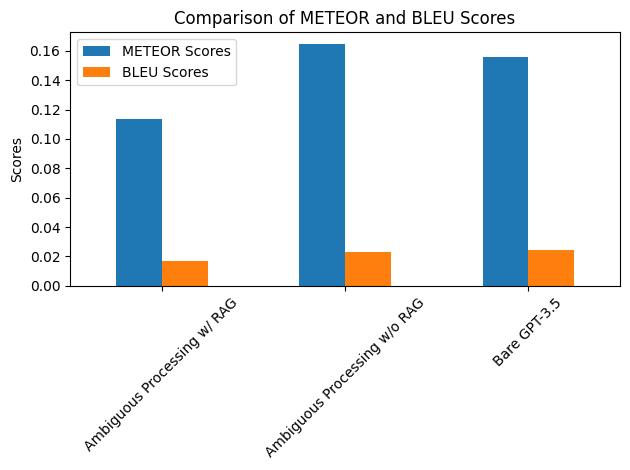

In [46]:
# Data provided by you
meteor_scores_plot = [0.11366781666441263, 0.16436857054788823, 0.15575274253547353]
bleu_scores_plt = [0.016821592920681017, 0.02288390667192786, 0.02427511923077731]
index = ['Ambiguous Processing w/ RAG', 'Ambiguous Processing w/o RAG', 'Bare GPT-3.5']
df = pd.DataFrame({'METEOR Scores': meteor_scores_plot, 'BLEU Scores': bleu_scores_plt}, index=index)

# Creating the plot with adjusted settings
plt.figure(figsize=(10, 6))  # Increase the size of the plot for better spacing
ax = df.plot.bar(rot=45)  # Rotate the labels to 45 degrees
plt.title("Comparison of METEOR and BLEU Scores")
plt.ylabel("Scores")
plt.tight_layout()  # Adjust the layout to fit the labels
plt.show()